## Question 2: Implementing Physics Informed Neural Networks (PINNs)

**Objective**: Implement and analyze a Physics-Informed Neural Network (PINN) that uses a two-layer Multilayer Perceptron (MLP) to solve a specified first-order elliptic Partial Differential Equation (PDE) subject to appropriate boundary conditions.


**Background**: Physics-Informed Neural Networks integrate differential equations that govern physical laws directly into the learning process, allowing the network to not only fit given data but also satisfy the known physical laws. PINNs are particularly useful for solving complex PDEs where traditional numerical methods might be challenging to implement.

For this assignment, focus on a first-order elliptic PDE, which is common in various areas of physics and engineering, such as heat transfer, fluid dynamics, and electromagnetism.

You can refer to https://www.sciencedirect.com/science/article/pii/S0021999118307125 for further reading.

We consider the following first-order elliptic PDE over a domain $\Omega$:
$$-\nabla\cdot(a(x)\nabla u(x)) = f(x), x\in\Omega$$
$$u(x) = g(x), x\in\partial \Omega$$

We have $u(x)\in\mathbb{R}, x\in\mathbb{R}^2, a(x) = x^T x$, $f(x) = \sin(x^T x), g(x) = x^T x$, and $\Omega = [0,1]\times[0,1]$ is a unit cube.

PINNs minimize the residual loss given as:

$$\mathcal{L}_{residual} = E_{x\in\Omega}\|-\nabla\cdot(a(x)\nabla u_{\theta}(x)) - f(x)\| + E_{x\in\partial\Omega}\|u_{\theta}(x) - g(x)\|$$

where $\theta$ is your neural network's parameters.


**Problem 1**: Now, we define a two layer MLP for this PDE, and sample $100, 1000,$ and $10000$ points in $\Omega$ and $100, 1000,$ and $10000$ points in $\partial\Omega$, in total $200, 2000,$ and $20000$ points to approximate the PDE residuals.

The samples can be generated by uniformly by sampling on the boundary $\partial\Omega$ and inside the domain $\Omega$. You can use torch.rand.

You should notice your PINN's performance improve as you increase the number of samples used to calculate the PDE residuals.

Pinns are a really intresitn concept, the main way the work is using a regularizer. So in your loss you penalize over your data and than you penalize over a loss. 

The non nonlienaryt way to do this would be to use a projection on the answerspace from teh data or from the dataspae on answer but this is a more expressive way to do this. 

When doing say newton's second law of motions you can easilly do PNNs with a diff eq for gravity and you don't need any boundary conditions or such

If you want though you can incpororate boundary conditions you can add a loss that satisifes this condition! these are an intresting concept! I like them very much


In [1]:
"""
NOTE ABOUT THE PDE AND BOUNDARY CONDITION:

The assignment states: 
    a(x) = x^T x,     f(x) = sin(x^T x),     g(x) = x^T x
but these choices do NOT perfectly match. If we plug u(x)=x^2 + y^2 
into -∇·(a(x)∇u(x)), we get -8(x^T x), not sin(x^T x). 
Hence, there's an inherent mismatch: the PDE's "true solution" for 
f(x)=sin(x^T x) is not simply x^2 + y^2 on the boundary.

As a result, the PINN can (and does) reduce the loss, but the final 
residual won't be near-zero. I have not changed anything here just making
an observation
"""

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from torch.autograd import grad


EPOCHS       = 2000          # Number of training epochs
HIDDEN_UNITS = 100           # Increase hidden units for a bit more capacity
PRINT_FREQ   = 50            # Print loss every PRINT_FREQ epochs
LR           = 0.001         # Learning rate

device = torch.device('cuda' if torch.cuda.is_available() else 'mps')
print(f"Using device: {device}")

torch.manual_seed(42)
np.random.seed(42)

class TwoLayerMLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(TwoLayerMLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.Tanh(),  
            nn.Linear(hidden_size, output_size)
        )

    def forward(self, x):
        return self.net(x)

def a_func(x):
    return torch.sum(x**2, dim=1)

def f_func(x):
    return torch.sin(torch.sum(x**2, dim=1))

def g_func(x):
    return torch.sum(x**2, dim=1)

def pde_residual(model, x, a_func, f_func):
    """
    Compute PDE residual for: -∇·(a(x)*∇u(x)) = f(x)
    """
    x.requires_grad_(True)

    # Forward pass: u(x)
    u = model(x)  # shape: [N, 1] or [N]

    # grad_u: partial derivatives of u wrt x
    grad_u = grad(
        outputs=u,
        inputs=x,
        grad_outputs=torch.ones_like(u),
        create_graph=True
    )[0]  # shape: [N, 2]

    # a(x)
    a_x = a_func(x).unsqueeze(1)  # shape: [N, 1]

    # a(x)*grad(u)
    a_grad_u = a_x * grad_u  # shape: [N, 2]

    # Divergence of a(x)*grad(u)
    #   div(a_grad_u) = d/dx1(...) + d/dx2(...)
    du1_dx1 = grad(
        outputs=a_grad_u[:, 0],
        inputs=x,
        grad_outputs=torch.ones_like(a_grad_u[:, 0]),
        create_graph=True
    )[0][:, 0]

    du2_dx2 = grad(
        outputs=a_grad_u[:, 1],
        inputs=x,
        grad_outputs=torch.ones_like(a_grad_u[:, 1]),
        create_graph=True
    )[0][:, 1]

    div_a_grad_u = du1_dx1 + du2_dx2

    # PDE residual
    #   residual = -∇·(a(x)*∇u(x)) - f(x)
    residual = -div_a_grad_u - f_func(x)

    return residual

def loss_function(model, x_boundary, x_interior, a_func, f_func, g_func):
    u_boundary  = model(x_boundary).squeeze()
    g_boundary  = g_func(x_boundary)
    boundary_mse = torch.mean((u_boundary - g_boundary)**2)

    r_interior = pde_residual(model, x_interior, a_func, f_func)
    residual_mse = torch.mean(r_interior**2)

    return boundary_mse + residual_mse, boundary_mse, residual_mse

def generate_boundary_points(n_points):
    points_per_edge = n_points // 4

    bottom = torch.stack([
        torch.rand(points_per_edge), 
        torch.zeros(points_per_edge)
    ], dim=1)

    top = torch.stack([
        torch.rand(points_per_edge),
        torch.ones(points_per_edge)
    ], dim=1)

    left = torch.stack([
        torch.zeros(points_per_edge),
        torch.rand(points_per_edge)
    ], dim=1)

    right = torch.stack([
        torch.ones(points_per_edge),
        torch.rand(points_per_edge)
    ], dim=1)

    x_boundary = torch.cat([bottom, top, left, right], dim=0)

    # If integer division left some remainder, add more boundary points
    if x_boundary.shape[0] < n_points:
        extra = n_points - x_boundary.shape[0]
        extra_boundary = torch.rand(extra, 2)
        for i in range(extra):
            dim  = i % 2
            side = (i // 2) % 2
            extra_boundary[i, dim] = float(side)
        x_boundary = torch.cat([x_boundary, extra_boundary], dim=0)

    return x_boundary.to(device)

def generate_interior_points(n_points):
    return torch.rand(n_points, 2).to(device)


Using device: mps


In [2]:
def train_model(model, optimizer, epochs, x_boundary, x_interior, a_func, f_func, g_func):
    model.train()
    loss_history        = []
    boundary_loss_hist  = []
    pde_loss_hist       = []

    for epoch in range(epochs):
        optimizer.zero_grad()

        total_loss, boundary_mse, residual_mse = loss_function(
            model, x_boundary, x_interior, a_func, f_func, g_func
        )
        total_loss.backward()
        optimizer.step()

        # Store
        loss_history.append(total_loss.item())
        boundary_loss_hist.append(boundary_mse.item())
        pde_loss_hist.append(residual_mse.item())

        # Print progress more frequently
        if epoch % PRINT_FREQ == 0:
            print(f"Epoch {epoch:4d}, "
                  f"Total Loss: {total_loss.item():.6f}, "
                  f"Boundary Loss: {boundary_mse.item():.6f}, "
                  f"PDE Loss: {residual_mse.item():.6f}")

    return loss_history, boundary_loss_hist, pde_loss_hist

def evaluate_model(model, n_points=100):
    x = torch.linspace(0, 1, n_points)
    y = torch.linspace(0, 1, n_points)
    X, Y = torch.meshgrid(x, y)

    xy = torch.stack([X.flatten(), Y.flatten()], dim=1).to(device)

    with torch.no_grad():
        Z = model(xy).cpu()

    Z = Z.reshape(n_points, n_points)
    return X.numpy(), Y.numpy(), Z.numpy()

def exact_solution(n_points=100):
    x = np.linspace(0, 1, n_points)
    y = np.linspace(0, 1, n_points)
    X, Y = np.meshgrid(x, y)
    Z = X**2 + Y**2
    return X, Y, Z

def plot_results(model, sample_size):
    X, Y, Z_pred = evaluate_model(model)
    X_exact, Y_exact, Z_exact = exact_solution()

    # Error w.r.t. x^2 + y^2 
    # (Again: This is NOT the PDE's real solution, 
    #  just the boundary condition function.)
    Z_error = np.abs(Z_pred - Z_exact)

    # Plot predicted
    fig = plt.figure(figsize=(18, 6))

    ax1 = fig.add_subplot(131, projection='3d')
    surf1 = ax1.plot_surface(X, Y, Z_pred, cmap=cm.viridis, linewidth=0)
    ax1.set_title(f'Predicted (n={sample_size})')
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    ax1.set_zlabel('u(x,y)')
    fig.colorbar(surf1, ax=ax1, shrink=0.5)

    # Plot "exact" boundary function for reference
    ax2 = fig.add_subplot(132, projection='3d')
    surf2 = ax2.plot_surface(X_exact, Y_exact, Z_exact, cmap=cm.viridis, linewidth=0)
    ax2.set_title('Reference: x^2 + y^2')
    ax2.set_xlabel('x')
    ax2.set_ylabel('y')
    ax2.set_zlabel('u(x,y)')
    fig.colorbar(surf2, ax=ax2, shrink=0.5)

    # Plot error
    ax3 = fig.add_subplot(133, projection='3d')
    surf3 = ax3.plot_surface(X, Y, Z_error, cmap=cm.hot, linewidth=0)
    ax3.set_title('Absolute Error vs. x^2 + y^2')
    ax3.set_xlabel('x')
    ax3.set_ylabel('y')
    ax3.set_zlabel('Error')
    fig.colorbar(surf3, ax=ax3, shrink=0.5)

    plt.tight_layout()
    plt.show()

    # Print some stats
    print(f"Mean absolute error vs. g(x): {np.mean(Z_error):.6f}")
    print(f"Max absolute error vs.  g(x): {np.max(Z_error):.6f}")



=== Running experiment with 100 sample points ===
Epoch    0, Total Loss: 1.866866, Boundary Loss: 1.732247, PDE Loss: 0.134620
Epoch   50, Total Loss: 0.360832, Boundary Loss: 0.337677, PDE Loss: 0.023156
Epoch  100, Total Loss: 0.327553, Boundary Loss: 0.290464, PDE Loss: 0.037089
Epoch  150, Total Loss: 0.303147, Boundary Loss: 0.258819, PDE Loss: 0.044329
Epoch  200, Total Loss: 0.281526, Boundary Loss: 0.230232, PDE Loss: 0.051294
Epoch  250, Total Loss: 0.261004, Boundary Loss: 0.205807, PDE Loss: 0.055197
Epoch  300, Total Loss: 0.240139, Boundary Loss: 0.184738, PDE Loss: 0.055401
Epoch  350, Total Loss: 0.218449, Boundary Loss: 0.165512, PDE Loss: 0.052937
Epoch  400, Total Loss: 0.196091, Boundary Loss: 0.146931, PDE Loss: 0.049160
Epoch  450, Total Loss: 0.173726, Boundary Loss: 0.128551, PDE Loss: 0.045175
Epoch  500, Total Loss: 0.152542, Boundary Loss: 0.110832, PDE Loss: 0.041710
Epoch  550, Total Loss: 0.133945, Boundary Loss: 0.094356, PDE Loss: 0.039589
Epoch  600, T

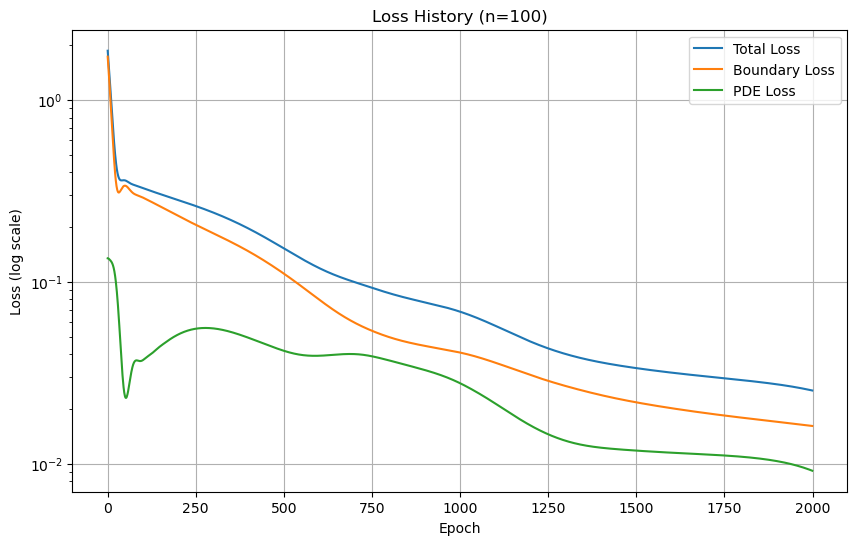

/opt/anaconda3/envs/deeplearning/lib/python3.10/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1729647065806/work/aten/src/ATen/native/TensorShape.cpp:3596.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


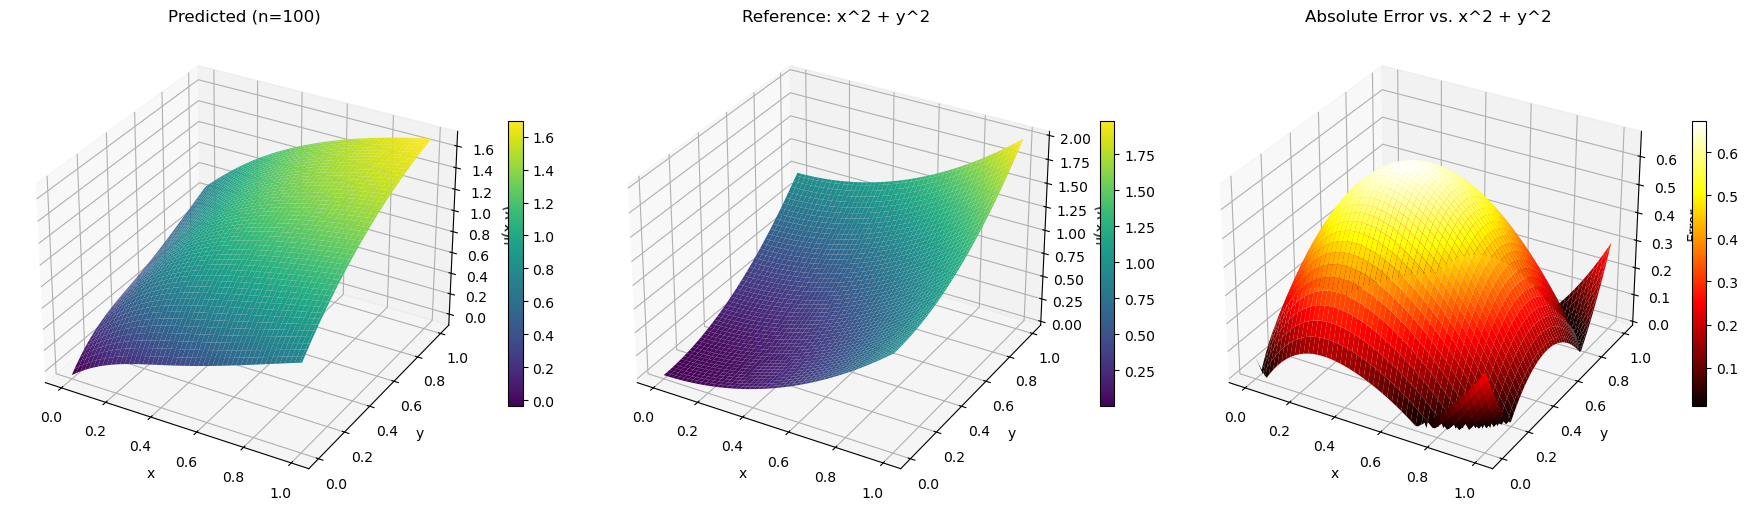

Mean absolute error vs. g(x): 0.334724
Max absolute error vs.  g(x): 0.673009

=== Running experiment with 1000 sample points ===
Epoch    0, Total Loss: 1.772791, Boundary Loss: 1.466420, PDE Loss: 0.306371
Epoch   50, Total Loss: 0.358020, Boundary Loss: 0.337929, PDE Loss: 0.020091
Epoch  100, Total Loss: 0.318547, Boundary Loss: 0.280446, PDE Loss: 0.038101
Epoch  150, Total Loss: 0.291012, Boundary Loss: 0.242173, PDE Loss: 0.048838
Epoch  200, Total Loss: 0.268462, Boundary Loss: 0.210099, PDE Loss: 0.058364
Epoch  250, Total Loss: 0.247340, Boundary Loss: 0.185378, PDE Loss: 0.061962
Epoch  300, Total Loss: 0.225590, Boundary Loss: 0.165209, PDE Loss: 0.060381
Epoch  350, Total Loss: 0.202757, Boundary Loss: 0.146523, PDE Loss: 0.056234
Epoch  400, Total Loss: 0.179394, Boundary Loss: 0.127411, PDE Loss: 0.051983
Epoch  450, Total Loss: 0.156666, Boundary Loss: 0.107884, PDE Loss: 0.048782
Epoch  500, Total Loss: 0.136011, Boundary Loss: 0.089473, PDE Loss: 0.046539
Epoch  550, 

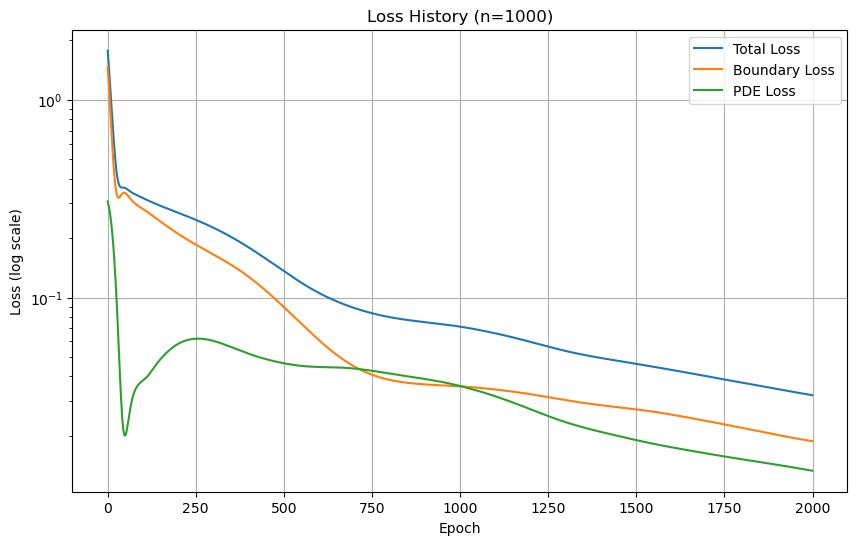

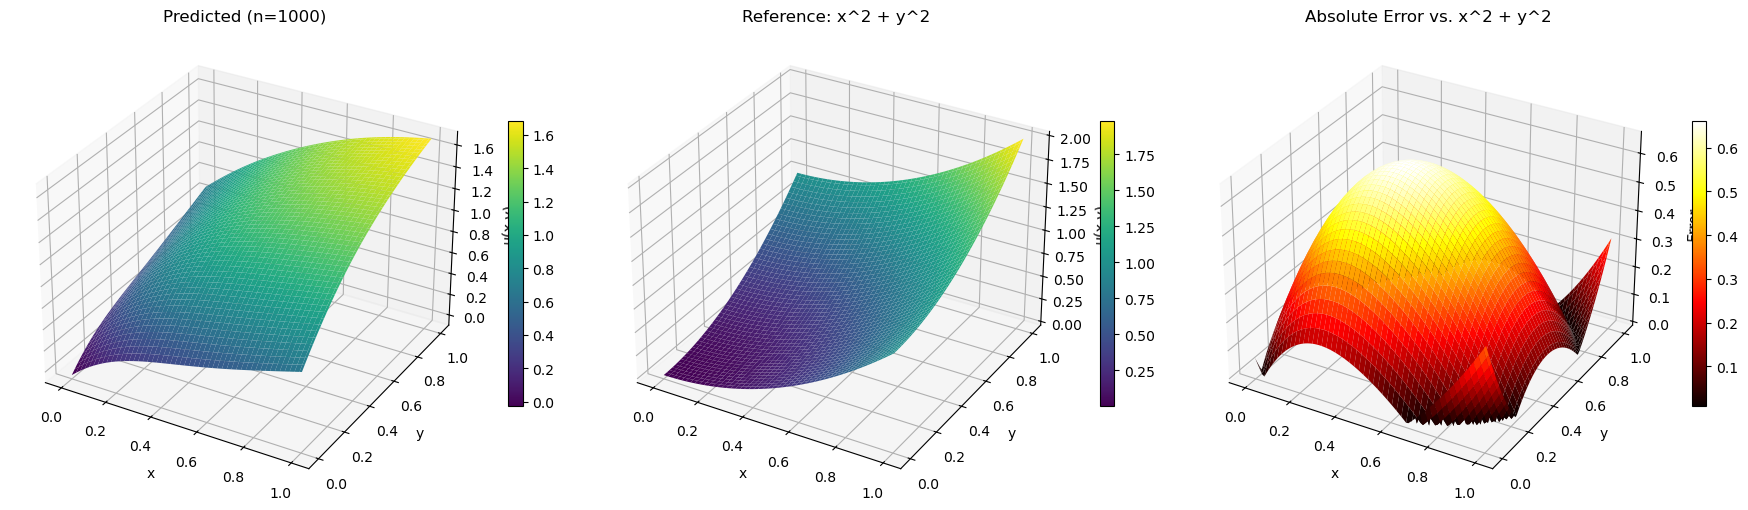

Mean absolute error vs. g(x): 0.325642
Max absolute error vs.  g(x): 0.661036

=== Running experiment with 10000 sample points ===
Epoch    0, Total Loss: 1.110543, Boundary Loss: 0.423607, PDE Loss: 0.686936
Epoch   50, Total Loss: 0.328587, Boundary Loss: 0.305194, PDE Loss: 0.023393
Epoch  100, Total Loss: 0.273940, Boundary Loss: 0.231461, PDE Loss: 0.042479
Epoch  150, Total Loss: 0.242650, Boundary Loss: 0.182520, PDE Loss: 0.060130
Epoch  200, Total Loss: 0.218740, Boundary Loss: 0.155112, PDE Loss: 0.063628
Epoch  250, Total Loss: 0.196096, Boundary Loss: 0.134954, PDE Loss: 0.061142
Epoch  300, Total Loss: 0.174171, Boundary Loss: 0.115615, PDE Loss: 0.058555
Epoch  350, Total Loss: 0.153128, Boundary Loss: 0.097159, PDE Loss: 0.055970
Epoch  400, Total Loss: 0.133651, Boundary Loss: 0.080835, PDE Loss: 0.052816
Epoch  450, Total Loss: 0.116772, Boundary Loss: 0.067439, PDE Loss: 0.049333
Epoch  500, Total Loss: 0.103511, Boundary Loss: 0.056844, PDE Loss: 0.046667
Epoch  550,

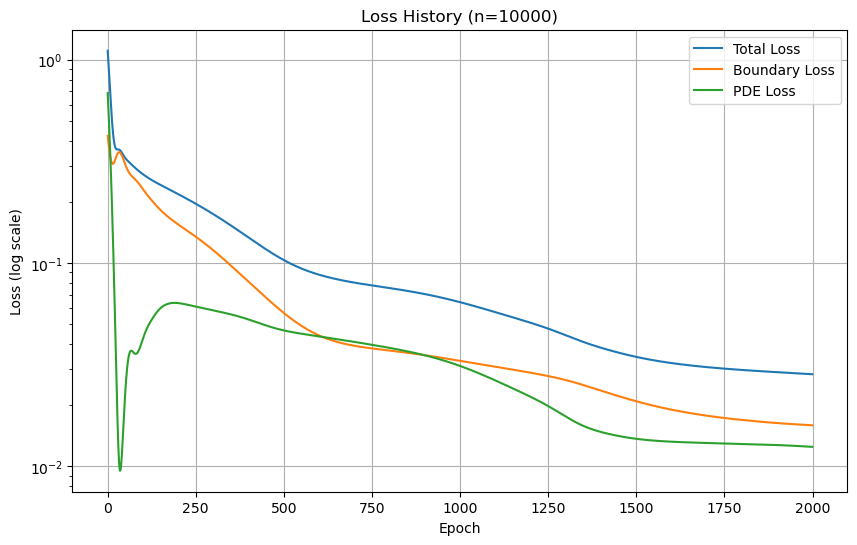

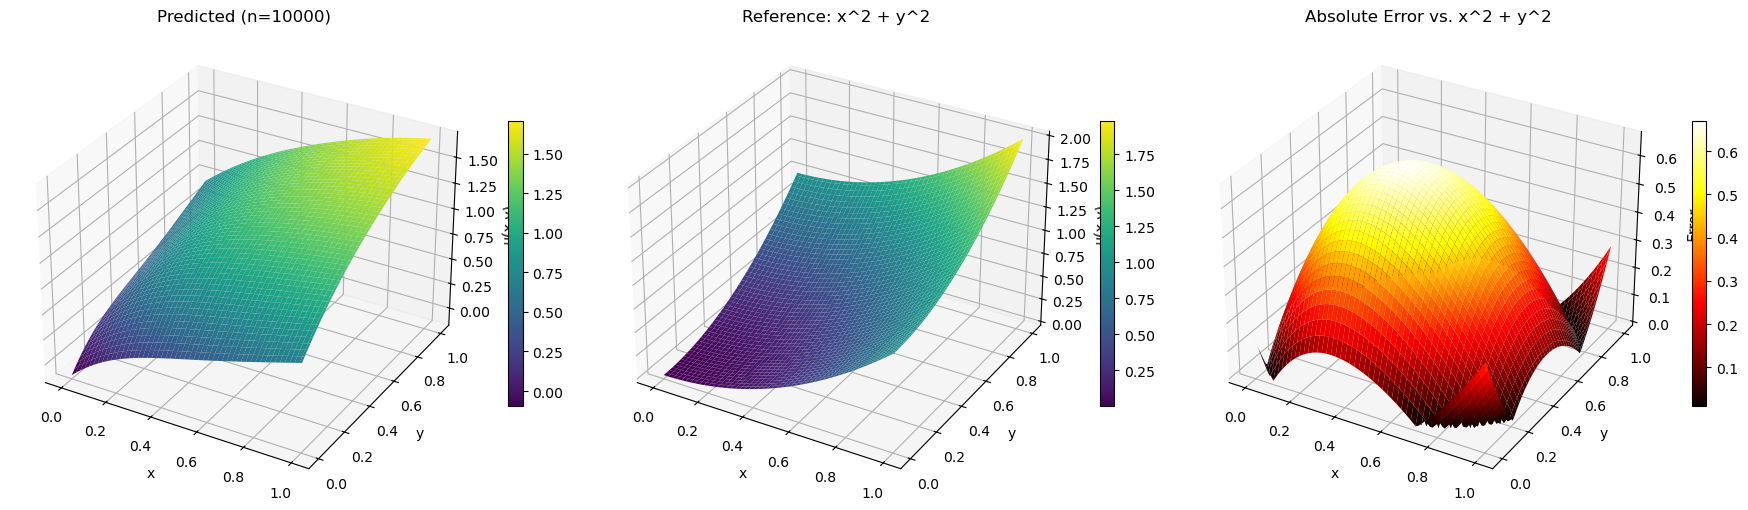

Mean absolute error vs. g(x): 0.331002
Max absolute error vs.  g(x): 0.669551


In [3]:


sample_sizes = [100, 1000, 10000]  # boundary & interior each, so total 2n

for n in sample_sizes:
    print(f"\n=== Running experiment with {n} sample points ===")
    
    x_boundary = generate_boundary_points(n)
    x_interior = generate_interior_points(n)

    model = TwoLayerMLP(
        input_size=2, hidden_size=HIDDEN_UNITS, output_size=1
    ).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)

    loss_history, boundary_loss_hist, pde_loss_hist = train_model(
        model, optimizer, EPOCHS,
        x_boundary, x_interior,
        a_func, f_func, g_func
    )

    plt.figure(figsize=(10,6))
    plt.semilogy(loss_history, label='Total Loss')
    plt.semilogy(boundary_loss_hist, label='Boundary Loss')
    plt.semilogy(pde_loss_hist, label='PDE Loss')
    plt.title(f'Loss History (n={n})')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (log scale)')
    plt.grid(True)
    plt.legend()
    plt.show()

    plot_results(model, n)


